In [1]:
# %load /home/jonathan/.ipython/profile_default/startup/startup-01.py
# start up settings for ipython
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os, sys

plt.style.use('ggplot')
plt.rcParams['font.size'] = 15.0
plt.rcParams['axes.labelsize'] = 15.0
plt.rcParams['xtick.labelsize'] = 15.0
plt.rcParams['ytick.labelsize'] = 15.0
plt.rcParams['legend.fontsize'] = 15.0

%matplotlib inline

# set the max column width
pd.options.display.max_colwidth = 1000


## Import data

In [2]:
tender_df = pd.read_csv('../../data/processed07Oct/tender.csv')
tprod_df = pd.read_csv('../../data/processed07Oct/tenderProduct.csv')

In [3]:
'Tender df shape: {}'.format(tender_df.shape)
'Tender product df shape: {}'.format(tprod_df.shape)

'Tender df shape: (17165, 84)'

'Tender product df shape: (74799, 13)'

### Only analyze sold tenders

In [4]:
tsold_df = tender_df[(tender_df['Estado']=='Adjudicada')]
tsprod_df = tprod_df[(tprod_df['CodigoExterno'].isin(tsold_df['CodigoExterno'].tolist()))]

In [5]:
'Sold tender df shape: {} as {:.2f}% of the original'.format(tsold_df.shape, tsold_df.shape[0]/tender_df.shape[0] * 100)
'Sold tender product df shape: {} as {:.2f}% of the original'.format(tsprod_df.shape, tsprod_df.shape[0]/tprod_df.shape[0] * 100)

'Sold tender df shape: (13430, 84) as 78.24% of the original'

'Sold tender product df shape: (65707, 13) as 87.84% of the original'

## Address the data limitation by removing all tenders that have only one tender product

In [6]:
grouped_tsprod_tid = tsprod_df.groupby('CodigoExterno').size()
grouped_tsprod_tid_df = grouped_tsprod_tid.to_frame()
grouped_tsprod_tid_df.columns = ['num_of_tprod']

In [7]:
grouped_tsprod_tid_1_prod_df = grouped_tsprod_tid_df[(grouped_tsprod_tid_df['num_of_tprod']==1)]
perc_of_orig = grouped_tsprod_tid_1_prod_df.shape[0] / tsold_df.shape[0] * 100
'Number of sold tenders with one tender product: {} as {:.2f}% of the original'.format(grouped_tsprod_tid_1_prod_df.shape[0], perc_of_orig)

'Number of sold tenders with one tender product: 8701 as 64.79% of the original'

In [8]:
tsold_np_df = tsold_df[~(tsold_df['CodigoExterno'].isin(grouped_tsprod_tid_1_prod_df.index.values))]
tsprod_np_df = tsprod_df[~(tsprod_df['CodigoExterno'].isin(grouped_tsprod_tid_1_prod_df.index.values))]

In [9]:
perc_of_orig = tsold_np_df.shape[0] / tsold_df.shape[0] * 100
'Sold tender with >1 tprod df shape: {} as {:.2f}% of the sold'.format(tsold_np_df.shape, perc_of_orig)
perc_of_orig = tsprod_np_df.shape[0] / tsprod_df.shape[0] * 100
'Sold tender product with >1 tprod df shape: {} as {:.2f}% of the sold'.format(tsprod_np_df.shape, perc_of_orig)

'Sold tender with >1 tprod df shape: (4729, 84) as 35.21% of the sold'

'Sold tender product with >1 tprod df shape: (57006, 13) as 86.76% of the sold'

This is quite interesting! Even though we are only looking at 35% of the sold tenders, they consists of 87% of the tender products! Of course, due to the mentioned problem with data quality, we do not know if the 14% actually consists of more tender products.

## Some simple visualization

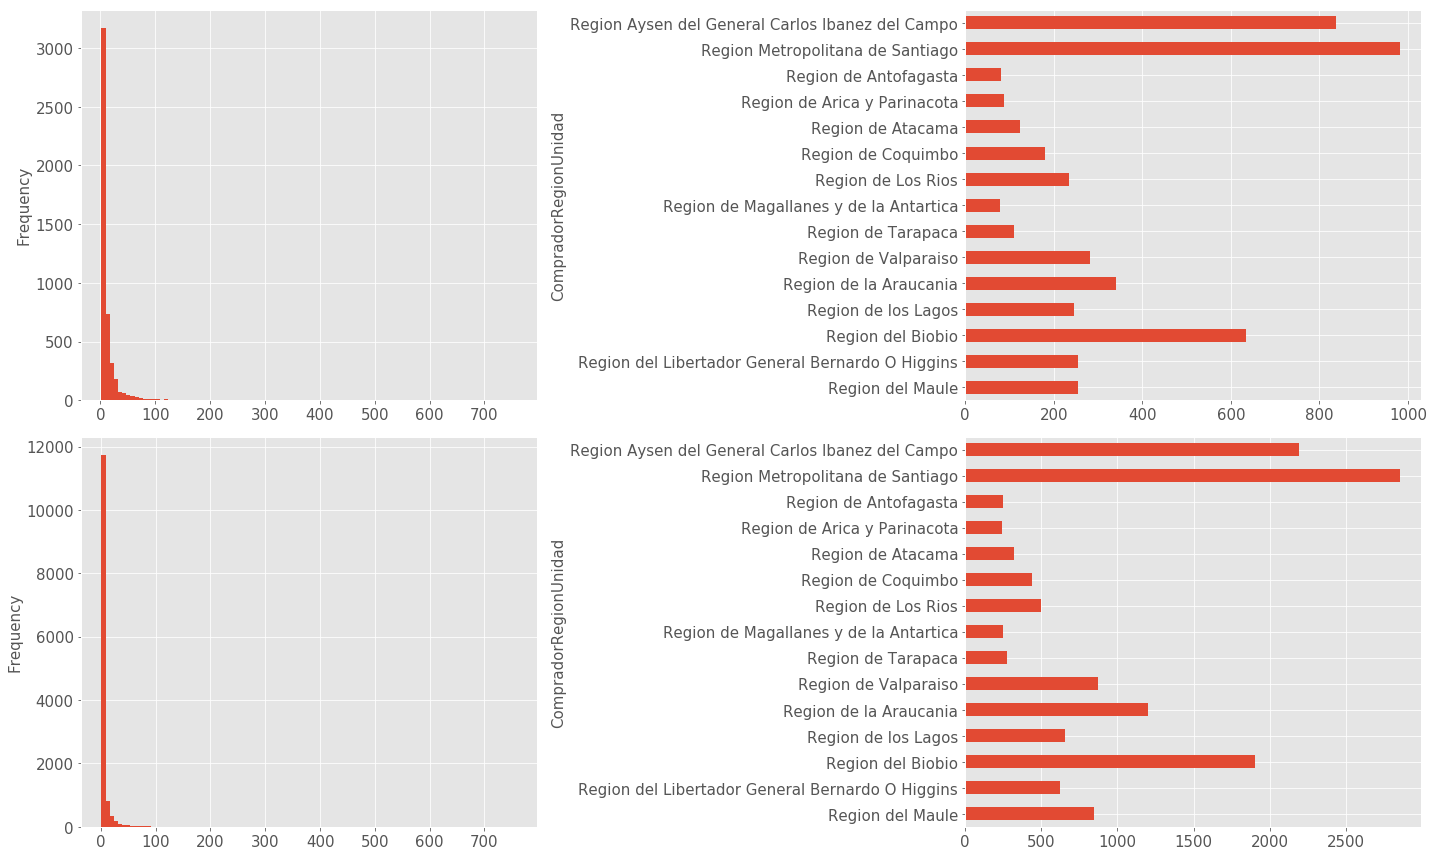

In [10]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(20, 12))
tsprod_np_df.groupby('CodigoExterno').size().plot.hist(bins=100, ax=axes[0, 0])
tsold_np_df.groupby('CompradorRegionUnidad').size().sort_index(inplace=False, ascending=False).plot(kind='barh', ax=axes[0,1])

tsprod_df.groupby('CodigoExterno').size().plot.hist(bins=100, ax=axes[1, 0])
tsold_df.groupby('CompradorRegionUnidad').size().sort_index(inplace=False, ascending=False).plot(kind='barh', ax=axes[1, 1])
plt.tight_layout();

Interestingly, the distribution remains the same; perhaps the data quality problem is consistent over all regions?

## Compute the distribution of sold price for a particular product

In [11]:
tprod_df.columns

Index(['AdjudicacionCantidad', 'AdjudicacionMontoUnitario',
       'AdjudicacionNombreProveedor', 'AdjudicacionRutProveedor', 'Cantidad',
       'Categoria', 'CodigoCategoria', 'CodigoExterno', 'CodigoProducto',
       'Correlativo', 'Descripcion', 'NombreProducto', 'UnidadMedida'],
      dtype='object')

In [12]:
prod_list = tsprod_np_df['CodigoProducto'].value_counts().index.values
t10_prod_list = prod_list[:10]
prod_count_df = tsprod_np_df['CodigoProducto'].value_counts().to_frame().reset_index()
prod_count_df.columns = ['CodigoProducto', 'Count']
prod_count_df = tprod_df[['CodigoProducto', 'NombreProducto', 'Categoria', 'CodigoCategoria']].drop_duplicates(inplace=False).merge(prod_count_df, on='CodigoProducto')
prod_count_df.sort_values('Count', inplace=True, ascending=False)
prod_count_df.reset_index(drop=True, inplace=True)
tprod_df.loc[(tprod_df['CodigoProducto'].isin(t10_prod_list)), 'NombreProducto'].unique()

array(['Sutura', 'Suplementos vitaminicos', 'Unidades de laboratorio',
       'Reactivos de analizadores quimicos', 'Unidades dentales',
       'Reactivos o soluciones quimicos', 'Juguetes didacticos',
       'Cajas de medicamentos de servicios medicos de urgencia',
       'Dispositivos de sujecion protesica o accesorios', 'Farmacias'], dtype=object)

In [90]:
tender_df.CompradorNombreOrganismo.unique().shape

(762,)

In [14]:
tsprod_np_df[(tsprod_np_df['CodigoProducto']==t10_prod_list[4])&
            (tsprod_np_df['AdjudicacionMontoUnitario']==1)].shape

(0, 13)

In [29]:
tsold_np_df.columns

Index(['AdjudicacionFecha', 'AdjudicacionNumero',
       'AdjudicacionNumeroOferentes', 'AdjudicacionTipo',
       'AdjudicacionUrlActa', 'CantidadReclamos', 'CodigoEstado',
       'CodigoExterno', 'CodigoTipo', 'CompradorCargoUsuario',
       'CompradorCodigoOrganismo', 'CompradorCodigoUnidad',
       'CompradorCodigoUsuario', 'CompradorComunaUnidad',
       'CompradorDireccionUnidad', 'CompradorNombreOrganismo',
       'CompradorNombreUnidad', 'CompradorNombreUsuario',
       'CompradorRegionUnidad', 'CompradorRutUnidad', 'CompradorRutUsuario',
       'Contrato', 'Descripcion', 'DiasCierreLicitacion', 'DireccionEntrega',
       'DireccionVisita', 'EmailResponsableContrato', 'EmailResponsablePago',
       'EsBaseTipo', 'EsRenovable', 'Estado', 'EstadoEtapas',
       'EstadoPublicidadOfertas', 'Estimacion', 'Etapas', 'ExtensionPlazo',
       'FechaCierre', 'FechasFechaActoAperturaEconomica',
       'FechasFechaActoAperturaTecnica', 'FechasFechaAdjudicacion',
       'FechasFechaCierre',

In [85]:
tprods = tsprod_np_df[
#    (tsprod_np_df['CodigoCategoria']==60141000)&
    (tsprod_np_df['CodigoProducto']==51191905)&
#    (tsprod_np_df['NombreProducto']=='Verduras frescas')&
#    (tsprod_np_df['UnidadMedida']=='kilogramo')&
    (tsprod_np_df['AdjudicacionMontoUnitario']>1)&
    (tsprod_np_df['AdjudicacionCantidad']>1)
]
tids = tprods['CodigoExterno'].unique()
tenders = tsold_np_df[(tsold_np_df['CodigoExterno'].isin(tids))]
tenders = tenders.merge(tprods, on='CodigoExterno')
tenders = tenders[
    (tenders['Descripcion_y'].str.lower().str.contains('vitamina'))&
    (tenders['Descripcion_y'].str.lower().str.contains('gota'))    
]
# tenders['AdjudicacionMontoUnitario'] = tenders['AdjudicacionMontoUnitario'] / 1000
tenders[['CompradorRegionUnidad', 'AdjudicacionMontoUnitario']].groupby('CompradorRegionUnidad').describe()

AdjudicacionMontoUnitario  \
                                                                     count   
CompradorRegionUnidad                                                        
Region Aysen del General Carlos Ibanez del Campo                       5.0   
Region Metropolitana de Santiago                                       3.0   
Region de Atacama                                                      3.0   
Region de Los Rios                                                     1.0   
Region de Valparaiso                                                   1.0   
Region de los Lagos                                                    1.0   
Region del Biobio                                                      1.0   
Region del Maule                                                       2.0   

                                                                             \
                                                          mean          std   
CompradorRegionUnidad                                                         
Region Aysen del General Carlos Ibanez del Campo    830.600000   163.168012   
Region Metropolitana de Santiago                   3648.333333  5060.764007   
Region de Atacama                                   775.000000    84.017855   
Region de Los Rios                                 9492.000000          NaN   
Region de Valparaiso                                898.000000          NaN   
Region de los Lagos                               10600.000000          NaN   
Region del Biobio                                   828.000000          NaN   
Region del Maule                                    725.000000     0.000000   

                                                                             \
                                                      min      25%      50%   
CompradorRegionUnidad                                                         
Region Aysen del General Carlos Ibanez del Campo    725.0    728.0    728.0   
Region Metropolitana de Santiago                    725.0    726.5    728.0   
Region de Atacama                                   725.0    726.5    728.0   
Region de Los Rios                                 9492.0   9492.0   9492.0   
Region de Valparaiso                                898.0    898.0    898.0   
Region de los Lagos                               10600.0  10600.0  10600.0   
Region del Biobio                                   828.0    828.0    828.0   
Region del Maule                                    725.0    725.0    725.0   

                                                                    
                                                      75%      max  
CompradorRegionUnidad                                               
Region Aysen del General Carlos Ibanez del Campo    872.0   1100.0  
Region Metropolitana de Santiago                   5110.0   9492.0  
Region de Atacama                                   800.0    872.0  
Region de Los Rios                                 9492.0   9492.0  
Region de Valparaiso                                898.0    898.0  
Region de los Lagos                               10600.0  10600.0  
Region del Biobio                                   828.0    828.0  
Region del Maule                                    725.0    725.0

In [86]:
tenders[
    (tenders['CompradorRegionUnidad']=='Region Aysen del General Carlos Ibanez del Campo')
#    (tenders['CodigoExterno']=='2413-39-LE16')
][['AdjudicacionMontoUnitario', 'AdjudicacionCantidad', 'CodigoExterno', 'Descripcion_x', 'Descripcion_y']]

,AdjudicacionMontoUnitario,AdjudicacionCantidad,CodigoExterno,Descripcion_x,Descripcion_y
17,1100.0,50.0,1540-129-LE16,El Hospital Dr Augusto Essmann Burgos solicita la compra de adquisicion de vitaminas y/o suplementos alimenticios para aproximadamente 3 meses necesarios para los servicios clinicos del nuevo recinto hospitalario asegurando una atencion segura y de calidad Presupuesto cargado a puesta en marcha del Hospital,VITAMINA A/C/D FC 2 500UI/400UI/75MG 20 ML SOLUCION GOTAS ORALES
111,728.0,900.0,2335-199-LE16,LAS NECESIDADES DEL DEPTO DE SALUD DE LINARES EN LA ADQUISICION DE MEDICAMENTOS PARA SUS DIFERENTES ESTABLECIMIENTOS DE SALUD DE ACUERDO A LO SOLICITADO EN ORDEN DE PEDIDO N 878 879 880 881 882,VITAMINA ADC 30ml GOTAS ORALES
122,728.0,500.0,2664-29-LE16,MEDICAMENTOS BODEGA FARMACIA S/P N 20 2016,Polivitaminico ACD Gotas Pediatricas segun formula Vitamina A 3 000 UI Vitamina C 50 mg Vitamina D 400 UI Similar a Abecidin gotas
131,872.0,50.0,2688-45-LE16,USO ADQUISICION MEDICAMENTOS PARA CESFAM,VITAMINAS A C D GOTAS ORALES
195,725.0,600.0,4401-93-LE16,Solicitar al sector privado la Adquisicion de Medicamentos para el Departamento de Salud a objeto de recibir del proveedor segun se solicite en cada caso todos o parte de los productos descritos en el Anexo N 3 de la oferta economica bajo las caracteristicas tecnicas que se detallan en la siguiente licitacion,VITAMINA ACD GOTAS


In [87]:
tenders[
    (tenders['CompradorRegionUnidad']=='Region Metropolitana de Santiago') &
    (tenders['Descripcion_y'].str.lower().str.contains('vitamin'))
][['AdjudicacionMontoUnitario', 'AdjudicacionCantidad', 'CodigoExterno', 'Descripcion_x', 'Descripcion_y']]

,AdjudicacionMontoUnitario,AdjudicacionCantidad,CodigoExterno,Descripcion_x,Descripcion_y
62,728.0,486.0,2069-151-LQ16,El objeto de la presente licitacion es contar con un contrato de suministro que pueda satisfacer la demanda de medicamentos necesarios para entregar un correcto tratamiento a pacientes hospitalizados y ambulatorios del establecimiento conjuntamente con la implementacion de un sistema de frecuencia y periodicidad de entrega de los productos coordinado entre Hospital y el adjudicatario,2170180 VITAMINAS A D C 30 ML FRASCO GOTARIO
75,725.0,50.0,2153-100-LE16,FARMACOS NOVIEMBRE 2016,50 214 900 002 00 VITAMINAS ACD GOTA ORAL
127,9492.0,20.0,2669-195-L116,COMPRA DE MEDICAMENTOS PARA EL VITABOTICA,VITAMINA D 800 UI SIMILAR O SUPERIOR A D VIDA GOTAS FRASCO 10 ML


In [63]:
tsprod_np_df[
#    (tsprod_np_df['CodigoCategoria']==60141000)&
    (tsprod_np_df['CodigoProducto']==51191905)&
#    (tsprod_np_df['NombreProducto']=='Verduras frescas')&
#    (tsprod_np_df['UnidadMedida']=='kilogramo')&
    (tsprod_np_df['AdjudicacionMontoUnitario']>1)&
    (tsprod_np_df['AdjudicacionCantidad']>1)
]['AdjudicacionMontoUnitario'].describe()

count       231.000000
mean       4337.629177
std       15392.562440
min           3.000000
25%          84.000000
50%         725.000000
75%        5430.000000
max      198600.000000
Name: AdjudicacionMontoUnitario, dtype: float64

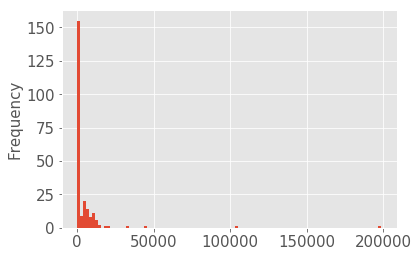

In [62]:
tsprod_np_df[
#    (tsprod_np_df['CodigoCategoria']==60141000)&
    (tsprod_np_df['CodigoProducto']==51191905)&
#    (tsprod_np_df['NombreProducto']=='Verduras frescas')&
#    (tsprod_np_df['UnidadMedida']=='kilogramo')&
    (tsprod_np_df['AdjudicacionMontoUnitario']>1)&
    (tsprod_np_df['AdjudicacionCantidad']>1)
]['AdjudicacionMontoUnitario'].plot.hist(bins=100)

## What happens to unsold tenders?

In [92]:
tender_df.Estado.unique()

array(['Adjudicada', 'Desierta o art 3 o 9 Ley 19 886', 'Cerrada',
       'Revocada', 'Suspendida'], dtype=object)

In [96]:
tdesert_df.columns

Index(['AdjudicacionFecha', 'AdjudicacionNumero',
       'AdjudicacionNumeroOferentes', 'AdjudicacionTipo',
       'AdjudicacionUrlActa', 'CantidadReclamos', 'CodigoEstado',
       'CodigoExterno', 'CodigoTipo', 'CompradorCargoUsuario',
       'CompradorCodigoOrganismo', 'CompradorCodigoUnidad',
       'CompradorCodigoUsuario', 'CompradorComunaUnidad',
       'CompradorDireccionUnidad', 'CompradorNombreOrganismo',
       'CompradorNombreUnidad', 'CompradorNombreUsuario',
       'CompradorRegionUnidad', 'CompradorRutUnidad', 'CompradorRutUsuario',
       'Contrato', 'Descripcion', 'DiasCierreLicitacion', 'DireccionEntrega',
       'DireccionVisita', 'EmailResponsableContrato', 'EmailResponsablePago',
       'EsBaseTipo', 'EsRenovable', 'Estado', 'EstadoEtapas',
       'EstadoPublicidadOfertas', 'Estimacion', 'Etapas', 'ExtensionPlazo',
       'FechaCierre', 'FechasFechaActoAperturaEconomica',
       'FechasFechaActoAperturaTecnica', 'FechasFechaAdjudicacion',
       'FechasFechaCierre',

In [114]:
tdesert_df = tender_df[(tender_df['Estado']=='Desierta o art 3 o 9 Ley 19 886')]
tdesert_df[(tdesert_df['CodigoExterno']=='1006-33-LE16')]['Nombre']

32    Convenio por Retiro Transporte y Disposicion final de residuos
Name: Nombre, dtype: object

In [105]:
tdesert_df.CodigoExterno

21        1003-65-LE16
23        1003-68-LE16
32        1006-33-LE16
33        1006-34-LE16
38        1019-93-L116
41        1020-44-LR16
53       1028-154-L116
61       1029-100-LE16
66       1029-105-L116
72       1029-112-L116
85        1030-91-L116
100       1039-31-LE16
101       1043-36-L116
107       1048-58-LE16
112       1048-64-LP16
124       1070-40-LE16
146       1096-13-L116
153       1106-47-E216
169      1145-136-L116
170      1145-137-L116
180       1151-19-LR16
181       1152-20-LP16
183       1154-19-L116
184       1154-20-L116
189       1155-76-LE16
193       1158-18-LE16
206      1161-144-L116
210       1162-22-LE16
218      1175-338-I216
222      1175-341-LE16
             ...      
17054      949-27-L116
17057     956-154-LE16
17060     956-157-LE16
17064     956-161-LE16
17065     956-162-L116
17078      975-70-LE16
17081      975-76-L116
17092     979-120-LQ16
17093     979-121-LQ16
17096     979-124-L116
17097     979-125-L116
17099     979-127-LE16
17101     9

In [131]:
tender_df[
    (tender_df['Nombre']=='EXAMENES Y PROCEDIMIENTO AGENDA MEDICA')&
    (tender_df['Estado'].str.contains('Desier'))
]

,AdjudicacionFecha,AdjudicacionNumero,AdjudicacionNumeroOferentes,AdjudicacionTipo,AdjudicacionUrlActa,CantidadReclamos,CodigoEstado,CodigoExterno,CodigoTipo,CompradorCargoUsuario,...,TipoDuracionContrato,TipoPago,TomaRazon,UnidadTiempo,UnidadTiempoContratoLicitacion,UnidadTiempoDuracionContrato,UnidadTiempoEvaluacion,ValorTiempoRenovacion,VisibilidadMonto,tender_product_duplicated
2175,NaN,NaN,0.0,NaN,http //www mercadopublico cl/Procurement/Modules/RFB/StepsProcessAward/PreviewAwardAct aspx qs bj1U V9WeXRjAKmeC9YclJWAnFjZ09MOO5MMSzhyTVQ,1580,7,1669-1587-L116,1,Ejecutiva de Compras,...,NaN,4,0,1,1,1,1.0,0,0,NaN


In [119]:
tender_df.loc[tender_df.duplicated('Nombre')][['Nombre', 'CodigoExterno', 'Estado']]

,Nombre,CodigoExterno,Estado
23,REPOSICION CUBIERTA LABORATORIO REG DE VIALIDAD,1003-68-LE16,Desierta o art 3 o 9 Ley 19 886
46,SUMINISTRO Y ASESORIA TECNICA SELLO ALTA FRICCION,1024-51-LE16,Adjudicada
47,SUMINISTRO Y ASESORIA TECNICA SELLO ALTA FRICCION,1024-52-LE16,Adjudicada
70,Suministro de Gravilla y Polvo Roca Drv Maule,1029-110-LE16,Adjudicada
165,Transmision de frases radiales,1128-12-L116,Adjudicada
184,SERVICIO DE TRANSPORTE LACUSTRE,1154-20-L116,Desierta o art 3 o 9 Ley 19 886
273,MANTENCION DE DOS CALDERA POLIDEPORTIVO CAR,1193-64-L116,Adjudicada
367,Servicio de Transporte de Pasajeros Terrestre,1333-9-LE16,Desierta o art 3 o 9 Ley 19 886
675,Gendarmeria requiere Servicio de Construccion,1413-123-L116,Adjudicada
677,Adquirir Seguros Gobernacion Provincial de Aysen,1415-17-E216,Adjudicada


In [111]:
tender_df[
    (tender_df['CompradorNombreOrganismo']=='MOP Direccion de Vialidad')
#    (tender_df['Descripcion'].str.lower().str.contains('instalaciones'))
][['Estado', 'Descripcion', 'CodigoExterno']]

,Estado,Descripcion,CodigoExterno
0,Adjudicada,Necesario para dar cumplimiento a labores de Conservacion y Administracion Directa de la Prov del Biobio Region del Biobio,1000-49-LE16
1,Adjudicada,Necesario para la vigilancia y custodia de maquinarias equipos y bodegas en el patio de la Oficina Provincial ubicado en la Comuna de Los Angeles Provincia de Biobio perteneciente a la Direccion de Vialidad Region del Biobio,1000-50-LE16
2,Adjudicada,La Direccion de Vialidad solicita ofertas para la contratacion del Servicio de Retiro Transporte y Disposicion final de residuos peligrosos segun Especificaciones Tecnica punto 9 26 de las Bases Administrativas necesarias para brindar las condiciones de seguridad y resguardo que los recintos requieren,1001-12-LE16
3,Adjudicada,La Direccion de Vialidad solicita ofertas para la adquisicion de Emulsion Asfaltica para Caminos Basicos para las faenas de mantencion en los Caminos Basicos de la Direccion de Vialidad en la Region de la Araucania conforme a los requerimientos de las presentes bases y especificaciones tecnicas descritas en las presentes Bases de Licitacion,1001-15-LP16
4,Adjudicada,La Direccion de Vialidad solicita ofertas para la adquisicion Materiales de topografia para el Departamento de Proyectos ubicado en Calle Bulnes N 897 Temuco conforme a los requerimientos de las presentes bases y especificaciones tecnicas descritas en las presentes Bases de Licitacion,1001-17-LE16
5,Adjudicada,La Direccion de Vialidad solicita ofertas para la adquisicion Barreras de Contencion para la unidad de Seguridad Vial de la Direccion Regional de Vialidad conforme a los requerimientos de las presentes bases y especificaciones tecnicas descritas en las presentes Bases de Licitacion,1001-18-LE16
6,Adjudicada,La Direccion de Vialidad solicita ofertas para la adquisicion Materiales para la reparacion de campamentos operativos recintos fiscales dependientes de la Direccion Regional de Vialidad conforme a los requerimientos de las presentes bases y especificaciones tecnicas descritas en las presentes Bases de Licitacion,1001-19-LE16
7,Adjudicada,Direccion de Vialidad X Region Direccion Regional,1002-100-LE16
8,Adjudicada,CAMINO CODIGO 70S1077,1002-61-LQ16
9,Adjudicada,Direccion de Vialidad X Region Direccion Regional,1002-91-LE16


/home/jonathan/anaconda3/lib/python3.5/site-packages/pandas/core/indexing.py:517: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


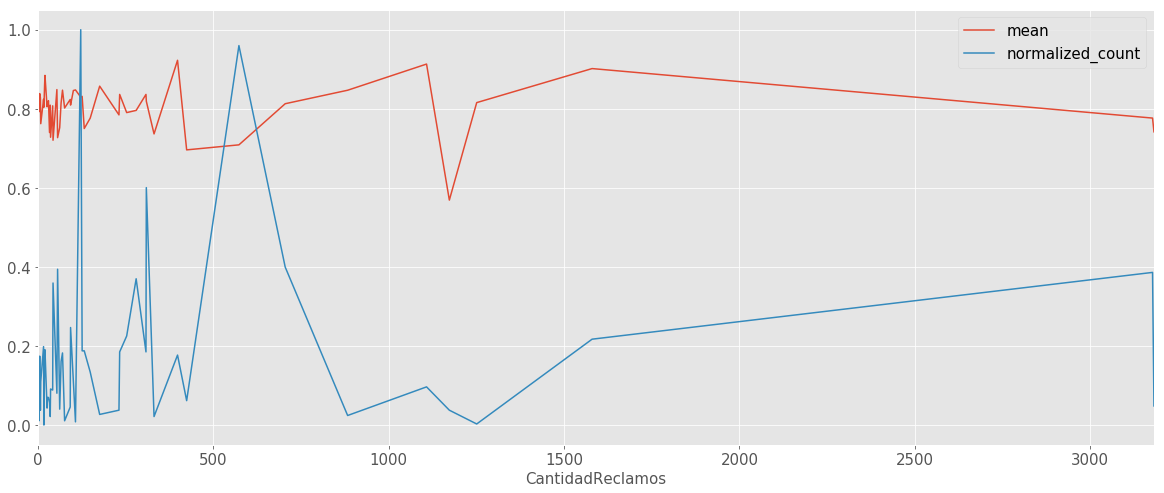

In [193]:
aux = tender_df[
    (tender_df['CodigoEstado'].isin([7, 8]))
]
aux.loc[:,'CodigoEstado'] = aux.loc[:,'CodigoEstado'] - 7

fig, ax = plt.subplots(figsize=(20, 8))
grp_complaint = aux[['CantidadReclamos', 'CodigoEstado']].groupby('CantidadReclamos').describe()
grp_complaint = grp_complaint['CodigoEstado']
grp_complaint = grp_complaint[(grp_complaint['count'] > 100)]
cnt_min = grp_complaint['count'].min()
cnt_max = grp_complaint['count'].max()
grp_complaint['normalized_count'] = grp_complaint['count'].apply(lambda x: (x - cnt_min)/(cnt_max - cnt_min))
grp_complaint[['mean', 'normalized_count']].plot(ax=ax)
# grp_complaint['mean'].reset_index().plot(kind='scatter', ax=ax, x='CantidadReclamos', y='mean', s=50)

In [134]:
tender_df.groupby('CantidadReclamos', as_index=False).apply(lambda x: x['Estado'].value_counts()[0] / x['Estado'].value_counts().sum())

0      0.748466
1      0.775194
2      0.798387
3      0.785047
4      0.716216
5      0.827586
6      0.740741
7      0.813559
8      0.753333
9      0.760870
10     0.900000
11     0.565217
12     0.818182
13     0.705882
14     0.884615
15     0.925000
16     0.816667
17     0.788462
18     0.815789
19     0.803371
20     0.881356
21     0.835052
22     0.843750
23     0.844444
24     0.700000
25     0.625000
26     0.751880
27     0.786765
28     0.802632
29     0.793651
         ...   
256    0.600000
257    1.000000
258    0.750000
259    0.728395
260    0.733333
261    0.892857
262    0.846154
263    1.000000
264    0.782609
265    0.586207
266    0.696970
267    0.727273
268    0.750000
269    0.916667
270    0.927273
271    0.876712
272    0.866667
273    0.500000
274    0.553719
275    0.814815
276    0.938272
277    1.000000
278    0.864865
279    1.000000
280    0.900524
281    0.600000
282    1.000000
283    0.760956
284    0.735537
285    1.000000
Length: 286, dtype: floa